In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# naive_times = pd.DatetimeIndex(start='2017', end='2018', freq='1h')
# naive_times = pd.DatetimeIndex(start='2018', end='2019', freq='1h')
naive_times = pd.DatetimeIndex(start='2009', end='2010', freq='1h')
# naive_times = pd.DatetimeIndex(start='2010', end='2011', freq='1h')  
####For different years the results are changing slightly (not significant)


# very approximate
# latitude, longitude, name, altitude, timezone
coordinates = [(35.2, -80.8, 'Charlotte', 232, 'Etc/GMT+4'),
(40, -105.3, 'Boulder', 1624, 'Etc/GMT+6'),
(42.3, -71.2, 'Boston', 43, 'Etc/GMT+4'),
(30, -110, 'Tucson', 700, 'Etc/GMT+7')]

import pvlib

# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

# specify constant ambient air temp and wind for simplicity
temp_air = 20

wind_speed = 0

In [2]:
system = {'module': module, 'inverter': inverter,
           'surface_azimuth': 180}

In [3]:
energies = {}
ac_locs = {}
NCF = {}  #Net Capacity Factor: Divide sum of generation by the number of periods times the system size
# NCF_monthly=pd.DataFrame(columns=[list(range(len(coordinates)))])
NCF_monthly={}


for latitude, longitude, name, altitude, timezone in coordinates:
        times = naive_times.tz_localize(timezone)
        system['surface_tilt'] = latitude
        solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
        dni_extra = pvlib.irradiance.get_extra_radiation(times)
        airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
        pressure = pvlib.atmosphere.alt2pres(altitude)
        am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
        tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
        cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
                                     dni_extra=dni_extra, altitude=altitude)
        aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
                                   solpos['apparent_zenith'], solpos['azimuth'])
        total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
                                                            system['surface_azimuth'],
                                                            solpos['apparent_zenith'],
                                                            solpos['azimuth'],
                                                            cs['dni'], cs['ghi'], cs['dhi'],
                                                            dni_extra=dni_extra,
                                                            model='haydavies')
        temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'],
                                             wind_speed, temp_air)
        effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
        dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
        ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)
        annual_energy = ac.sum()
        energies[name] = annual_energy
        interval=60
        system_capacity=220
        NCF[name]=annual_energy/(525600/int(interval) * system_capacity)
        ac_locs[name]=ac
        ac_mth_agg=ac.resample('M',how='sum')
        ncf_mon=ac_mth_agg/((740*60)/int(interval) * system_capacity)
        NCF_monthly[name]=pd.DataFrame(ncf_mon)


C:\Users\Mhdella\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


In [4]:
df_ac_locs=pd.DataFrame(ac_locs)
df_ac_locs
len(df_ac_locs.columns)
df_ac_magg=pd.DataFrame(ac_mth_agg)
# df_ac_magg
# ac_mth_agg
# len(df_ac_magg.columns)
# NCF_monthly

In [5]:
energies = pd.Series(energies)
NCF = pd.Series(NCF)
# based on the parameters specified above, these are in W*hrs
# print(energies.round(0))
decf = {'Energy':energies,'NCF':NCF}
df_E_NCF = pd.DataFrame(decf)
df_E_NCF

,Energy,NCF
Charlotte,446027.799635,0.231438
Boulder,491571.366495,0.255070
Boston,451884.866442,0.234477
Tucson,467719.102821,0.242694


Text(0,0.5,'Yearly energy yield (W hr)')

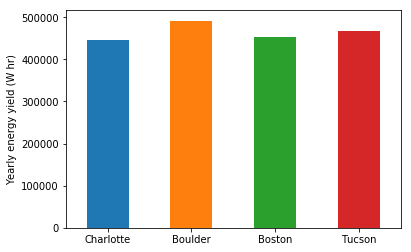

In [6]:
energies.plot(kind='bar', rot=0)

plt.ylabel('Yearly energy yield (W hr)')


In [7]:
energies.head()
ac.head()
# ac.describe()
annual_energy

467719.10282142775

In [8]:
system_capacity=220
max(ac)

187.70299856688567

In [9]:
# print(ac_mth_agg) 

In [10]:
ac_mth_agg/((740*60)/int(interval) * system_capacity)
#2.135943

2009-01-31 00:00:00-07:00    2.256831e-01
2009-02-28 00:00:00-07:00    2.229641e-01
2009-03-31 00:00:00-07:00    2.612959e-01
2009-04-30 00:00:00-07:00    2.528264e-01
2009-05-31 00:00:00-07:00    2.530378e-01
2009-06-30 00:00:00-07:00    2.366155e-01
2009-07-31 00:00:00-07:00    2.443669e-01
2009-08-31 00:00:00-07:00    2.500231e-01
2009-09-30 00:00:00-07:00    2.457021e-01
2009-10-31 00:00:00-07:00    2.459379e-01
2009-11-30 00:00:00-07:00    2.209296e-01
2009-12-31 00:00:00-07:00    2.135852e-01
2010-01-31 00:00:00-07:00   -1.228501e-07
Freq: M, dtype: float64

In [11]:
NCF_monthly

{'Charlotte':                                       0
 2009-01-31 00:00:00-04:00  2.111819e-01
 2009-02-28 00:00:00-04:00  2.164275e-01
 2009-03-31 00:00:00-04:00  2.472825e-01
 2009-04-30 00:00:00-04:00  2.417450e-01
 2009-05-31 00:00:00-04:00  2.443294e-01
 2009-06-30 00:00:00-04:00  2.288263e-01
 2009-07-31 00:00:00-04:00  2.367186e-01
 2009-08-31 00:00:00-04:00  2.374227e-01
 2009-09-30 00:00:00-04:00  2.359521e-01
 2009-10-31 00:00:00-04:00  2.363031e-01
 2009-11-30 00:00:00-04:00  2.070240e-01
 2009-12-31 00:00:00-04:00  1.965155e-01
 2010-01-31 00:00:00-04:00 -1.228501e-07,
 'Boulder':                                       0
 2009-01-31 00:00:00-06:00  2.291343e-01
 2009-02-28 00:00:00-06:00  2.319663e-01
 2009-03-31 00:00:00-06:00  2.754655e-01
 2009-04-30 00:00:00-06:00  2.692651e-01
 2009-05-31 00:00:00-06:00  2.694075e-01
 2009-06-30 00:00:00-06:00  2.556739e-01
 2009-07-31 00:00:00-06:00  2.662084e-01
 2009-08-31 00:00:00-06:00  2.701380e-01
 2009-09-30 00:00:00-06:00  2.58